In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [2]:
np.random.seed(0)
tf.random.set_seed(0)

import data

In [3]:
df = pd.read_csv('AirlineTweets.csv')

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
df = df[['airline_sentiment', 'text']]

<Axes: >

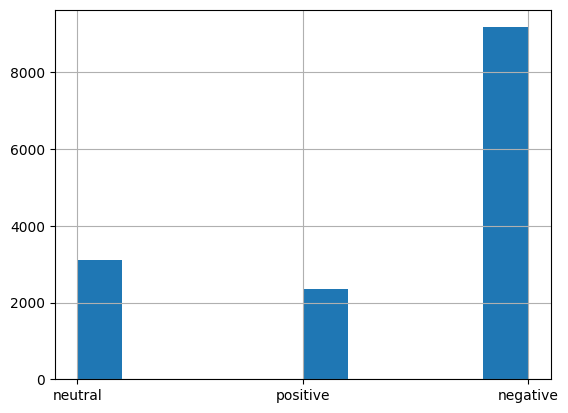

In [6]:
df['airline_sentiment'].hist()

In [7]:
df = df[df['airline_sentiment'] != 'neutral'].copy()

In [8]:
target_map = {'positive': 1, 'negative': 0}
df['target'] = df['airline_sentiment'].map(target_map)

In [9]:
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


train-test spilt

In [10]:
df_train, df_test = train_test_split(df, random_state=42)

vectorization with TF-IDF

In [11]:
vectorizer = TfidfVectorizer(max_features=2000)
X_train = vectorizer.fit_transform(df_train['text'])
X_test = vectorizer.transform(df_test['text'])

In [12]:
# data must not be sparse matrix before passing into tensorflow
X_train = X_train.toarray()
X_test = X_test.toarray()

In [13]:
Y_train = df_train['target']
Y_test = df_test['target']

In [16]:
X_train.shape[1]

2000

In [14]:
# input dimensions
D = X_train.shape[1]

neural network with
- Input Layer of 2000 neurons
- Dense Layer of 1 neuron with sigmoid activation
- BCE loss and Adam optimizer

In [15]:
# build model
i = Input(shape=(D,))
x = Dense(1)(i) # sigmoid included in loss

model = Model(i, x)

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 2000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,001 (7.82 KB)

 Trainable params: 2,001 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(
  loss=BinaryCrossentropy(from_logits=True),
  optimizer=Adam(learning_rate=0.01),
  metrics=['accuracy']
)

In [19]:
r = model.fit(
  X_train, Y_train,
  validation_data=(X_test, Y_test),
  epochs=40,
  batch_size=128,
)

Epoch 1/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7990 - loss: 0.5718 - val_accuracy: 0.8049 - val_loss: 0.3971
Epoch 2/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8009 - loss: 0.3818 - val_accuracy: 0.8219 - val_loss: 0.3394
Epoch 3/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8204 - loss: 0.3242 - val_accuracy: 0.8427 - val_loss: 0.3025
Epoch 4/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8465 - loss: 0.2846 - val_accuracy: 0.8614 - val_loss: 0.2768
Epoch 5/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8649 - loss: 0.2558 - val_accuracy: 0.8780 - val_loss: 0.2582
Epoch 6/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8811 - loss: 0.2340 - val_accuracy: 0.8891 - val_loss: 0.2443
Epoch 7/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8952 - loss: 0.2167 - val_accuracy: 0.8999 - val_loss: 0.2336
Epoch 8/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9039 - loss: 0.2028 - val_accuracy: 0.9040 - v

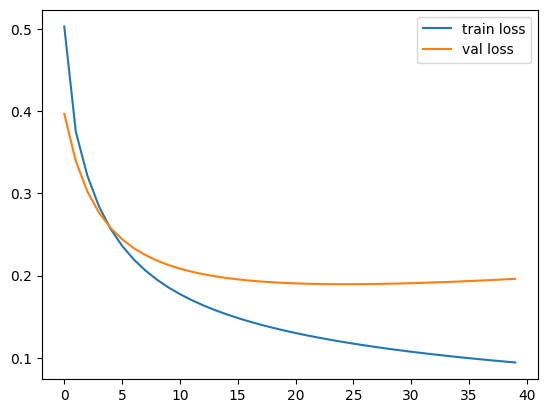

In [20]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

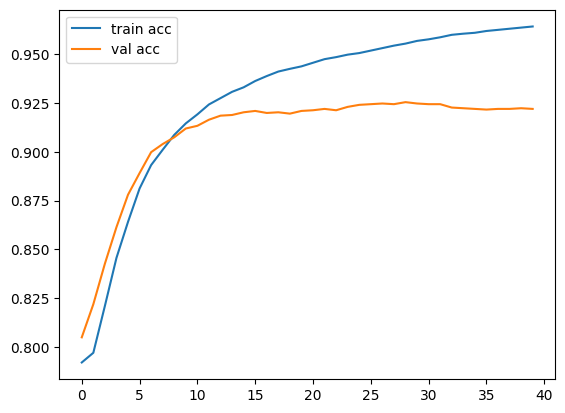

In [21]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [22]:
P_train = ((model.predict(X_train) > 0) * 1.0).flatten()
P_test = ((model.predict(X_test) > 0) * 1.0).flatten()

271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [23]:
cm = confusion_matrix(Y_train, P_train, normalize='true')
cm

array([[0.99037199, 0.00962801],
       [0.09666667, 0.90333333]])

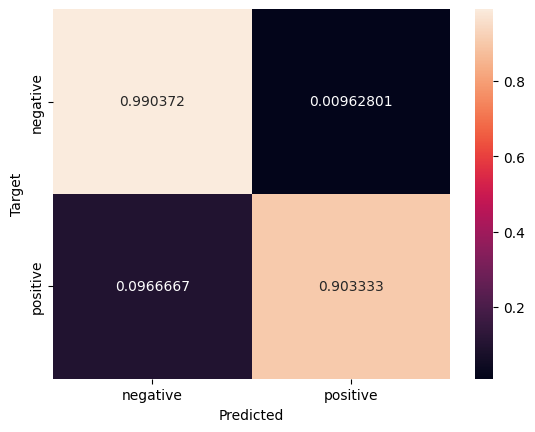

In [24]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  classes = ['negative', 'positive']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

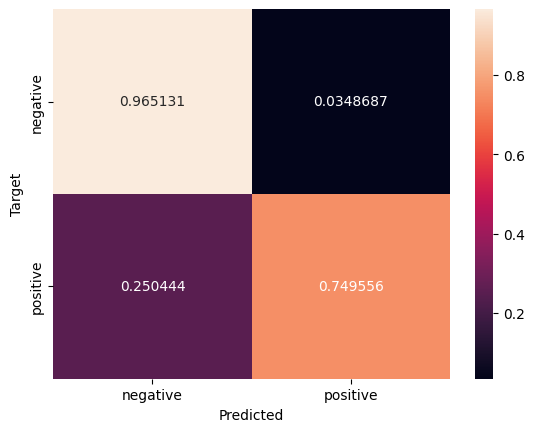

In [25]:
cm_test = confusion_matrix(Y_test, P_test, normalize='true')
plot_cm(cm_test)

In [26]:
Pr_train = model.predict(X_train)
Pr_test = model.predict(X_test)
print("Train AUC:", roc_auc_score(Y_train, Pr_train))
print("Test AUC:", roc_auc_score(Y_test, Pr_test))

271/271 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train AUC: 0.9948794878029015
Test AUC: 0.9534418728767617


In [27]:
print("Train F1:", f1_score(Y_train, P_train))
print("Test F1:", f1_score(Y_test, P_test))

Train F1: 0.9312714776632303
Test F1: 0.7917448405253283


In [28]:
model.layers

[<InputLayer name=input_layer, built=True>, <Dense name=dense, built=True>]

In [29]:
model.layers[1].get_weights()

[array([[-3.6977577],
        [ 3.3647256],
        [-1.6362861],
        ...,
        [ 1.9301127],
        [ 1.4452367],
        [-2.842127 ]], dtype=float32),
 array([-0.2356447], dtype=float32)]

In [30]:
w = model.layers[1].get_weights()[0]

In [31]:
word_index_map = vectorizer.vocabulary_
word_index_map

{'jetblue': np.int64(972),
 'thanks': np.int64(1724),
 'for': np.int64(749),
 'having': np.int64(851),
 'us': np.int64(1860),
 'hang': np.int64(834),
 'out': np.int64(1263),
 'at': np.int64(193),
 'tampa': np.int64(1706),
 'airport': np.int64(121),
 'forever': np.int64(752),
 'today': np.int64(1764),
 'it': np.int64(963),
 'really': np.int64(1420),
 'been': np.int64(239),
 'an': np.int64(146),
 'awesome': np.int64(213),
 'experience': np.int64(650),
 'americanair': np.int64(142),
 'was': np.int64(1897),
 'told': np.int64(1767),
 'you': np.int64(1992),
 'could': np.int64(446),
 'only': np.int64(1246),
 'refund': np.int64(1434),
 'me': np.int64(1109),
 'the': np.int64(1728),
 'cost': np.int64(442),
 'of': np.int64(1225),
 'my': np.int64(1180),
 'original': np.int64(1255),
 'return': np.int64(1476),
 'flight': np.int64(722),
 'note': np.int64(1212),
 'had': np.int64(824),
 'booked': np.int64(268),
 'more': np.int64(1165),
 'expensive': np.int64(649),
 'everyone': np.int64(631),
 'else': n

In [32]:
# let's look at the weights for each word
# try it with different threshold values!
threshold = 2

print("Most positive words:")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = w[index, 0]
    if weight > threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: -x[1])
for i in range(10):
  word, weight = word_weight_tuples[i]
  print(word, weight)

Most positive words:
thank 9.80922
thanks 9.403397
worries 8.657339
great 8.100669
love 7.4442954
awesome 7.4382796
excellent 7.170393
kudos 6.7824907
amazing 6.4585443
best 6.1936045


In [33]:
print("Most negative words:")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = w[index, 0]
    if weight < -threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: x[1])
for i in range(10):
  word, weight = word_weight_tuples[i]
  print(word, weight)

Most negative words:
worst -9.316067
paid -7.965944
not -7.8004913
rude -7.613593
nothing -6.9293084
disappointed -6.8771605
hung -6.8131204
website -6.7573256
instead -6.447957
weren -6.2409945
